### Model Sentimen 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def map_sentiment(sentiment):
    if sentiment == 1:
        return 'positif'
    elif sentiment == 0:
        return 'netral'
    else:
        return 'negatif'

In [3]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y

In [4]:
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [5]:
def plot_training_model_loss(clf, iterations, X, y):
    losses = []
    for i in range(iterations):
        clf.partial_fit(X, y, classes=np.unique(y))
        decision = clf.decision_function(X)
        hinge_loss = np.mean(np.maximum(0, 1 - decision[np.arange(len(y)), y]))
        losses.append(hinge_loss)
    plt.figure(figsize=(10, 6))
    plt.plot(range(iterations), losses, label='Training Loss')
    plt.title('Training Model')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
df = pd.read_csv('sentiment_3500.csv')
df['sentimen'] = df['sentimen'].map(map_sentiment)
df.head(10)

,content,sentimen
0,bacapres koalisi perubahan anies baswedan bert...,positif
1,calon presiden bacapres ganjar pranowo mengawa...,positif
2,bacapres ganjar pranowo bertemu seniman musisi...,positif
3,bacapres koalisi perubahan anies baswedan mere...,positif
4,bacapres koalisi perubahan anies baswedan meny...,positif
5,anies baswedan peringkat ketiga hasil survei a...,positif
6,relawan solidaritas ulama muda jokowi samawi m...,positif
7,bacapres koalisi indonesia maju kim prabowo su...,positif
8,bacapres ganjar pranowo mahfud md akrab mengha...,positif
9,baliho bergambar ketua umum partai gerindra pr...,positif


In [7]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)

In [8]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]

In [9]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

In [10]:
print("Shape of tfidf_train_features:", tfidf_train_features.shape)
print("Length of y_train_encoded:", len(y_train_encoded))

Shape of tfidf_train_features: (2450, 185406)
Length of y_train_encoded: 2450


In [11]:
print("Shape of tfidf_test_features:", tfidf_test_features.shape)
print("Length of y_test_encoded:", len(y_test_encoded))

Shape of tfidf_test_features: (1050, 185406)
Length of y_test_encoded: 1050


In [12]:
# Model training with specified number of iterations
clf = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3)
clf.partial_fit(tfidf_train_features, y_train_encoded, classes=np.unique(y_train_encoded))

SGDClassifier()

In [13]:
# Predictions
clf_pred = clf.predict(tfidf_test_features)

# Accuracy
clf_accuracy = accuracy_score(y_test_encoded, clf_pred)
print("Accuracy:", clf_accuracy)

Accuracy: 0.6523809523809524


In [14]:
# Classification Report
report = classification_report(y_test_encoded, clf_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     negatif       0.62      0.62      0.62       292
      netral       0.70      0.63      0.66       430
     positif       0.63      0.71      0.67       328

    accuracy                           0.65      1050
   macro avg       0.65      0.65      0.65      1050
weighted avg       0.65      0.65      0.65      1050



<Figure size 800x600 with 0 Axes>

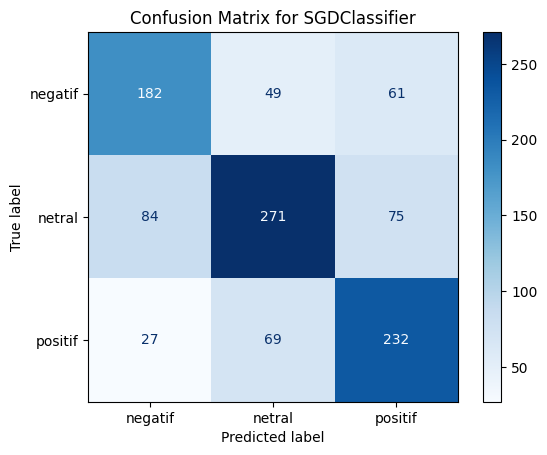

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, clf_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SGDClassifier')
plt.show()

## Naiye Bayes

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [17]:
# Train Naive Bayes model
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train_features, y_train_encoded)

MultinomialNB()

In [18]:
# Predictions
nb_pred = nb_classifier.predict(tfidf_test_features)

# Accuracy
nb_accuracy = accuracy_score(y_test_encoded, nb_pred)
print("Naive Bayes Accuracy:", nb_accuracy)

Naive Bayes Accuracy: 0.48


In [19]:
# Classification Report
nb_report = classification_report(y_test_encoded, nb_pred, target_names=label_encoder.classes_)
print("Naive Bayes Classification Report:\n", nb_report)

Naive Bayes Classification Report:
               precision    recall  f1-score   support

     negatif       0.77      0.25      0.38       292
      netral       0.44      0.95      0.60       430
     positif       0.88      0.06      0.12       328

    accuracy                           0.48      1050
   macro avg       0.69      0.42      0.37      1050
weighted avg       0.67      0.48      0.39      1050



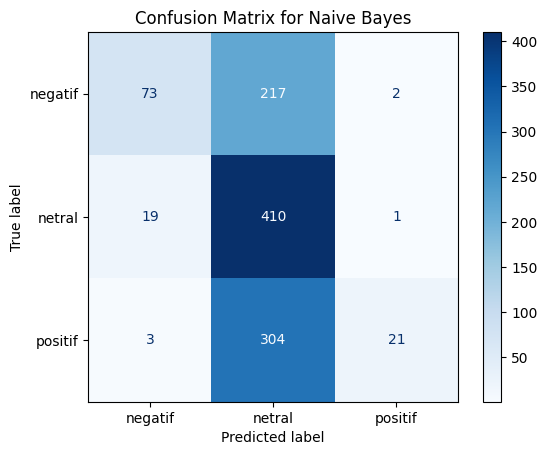

In [20]:
# Plot confusion matrix
nb_confusion_matrix = confusion_matrix(y_test_encoded, nb_pred)
nb_display = ConfusionMatrixDisplay(confusion_matrix=nb_confusion_matrix, display_labels=label_encoder.classes_)
nb_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

## SVM

In [21]:
from sklearn.svm import SVC

In [22]:
# Train SVM model
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(tfidf_train_features, y_train_encoded)


SVC(kernel='linear')

In [23]:
# Predictions
svm_pred = svm_classifier.predict(tfidf_test_features)

# Accuracy
svm_accuracy = accuracy_score(y_test_encoded, svm_pred)
print("SVM Accuracy:", svm_accuracy)

SVM Accuracy: 0.6638095238095238


In [24]:
# Classification Report
svm_report = classification_report(y_test_encoded, svm_pred, target_names=label_encoder.classes_)
print("SVM Classification Report:\n", svm_report)

SVM Classification Report:
               precision    recall  f1-score   support

     negatif       0.63      0.60      0.62       292
      netral       0.66      0.70      0.68       430
     positif       0.69      0.66      0.68       328

    accuracy                           0.66      1050
   macro avg       0.66      0.66      0.66      1050
weighted avg       0.66      0.66      0.66      1050



<Figure size 800x600 with 0 Axes>

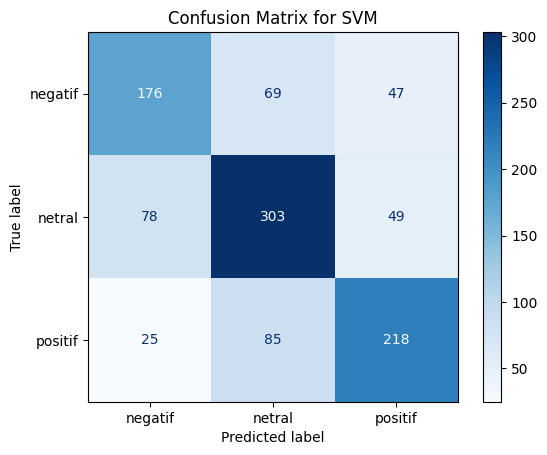

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

# Compute confusion matrix for SVM
svm_confusion_matrix = confusion_matrix(y_test_encoded, svm_pred)

# Plot confusion matrix for SVM
plt.figure(figsize=(8, 6))
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_confusion_matrix, display_labels=label_encoder.classes_)
svm_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SVM')
plt.show()